# Chapter 7 : Continuous AD

Did you know that there is 18000 commercial anaerobic digesters in Europe alone. You can have a look at this [website](https://www.europeanbiogas.eu/about-biogas-and-biomethane/) for more information. Most of these commercial digesters operate in a continuous mode, implying that steady state is achieved at most times. 

<img src="digest1.png" width="800" />

In this chapter we will be looking at continuous anaerobic digestion and how the growth and maintenance variables influence the steady state. Note that a continuous stream of substrate will be fed to the reactor and that solid and liquid digestate will be removed from the reactor in order to keep the contents in the reactor more or less constant. In this chapter the Monod inhibition and ammonia inhibition will be different for growth ($\mu$) and maintenance ($\theta$) as is often the case with micro-organisms. Under low substrate concentrations maintenance is typically favoured over growth to keep the organism viable. Also the inhibition characteristics of ammonia is different for growth and maintenance, where growth tends to be inhibited more at lower concentrations of ammonia.  


Let's start with an example where we neglegt inhibition. We'll use the same system as in chapter 6 and we will start by doing dynamic (time-dependant) simulations of the system in order to obtain the steady state. We will use the solution of the steady state via **fsolve** in conjuntion with the dynamic simulation.

The following video provides some assitance:

[Video: Continuous digesters](https://youtu.be/LK3QAARn1TE)


Let's import the stoicheometric matrices from chapter 6 to get started:

In [34]:
import numpy as numpy
import pandas
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

S1 = numpy.matrix(pandas.read_excel('matdig1.xlsx'))
S2 = numpy.matrix(pandas.read_excel('matdig2.xlsx'))

<img src="mat1.png" width="700" />

Let's get the cmol masses for substrate and biomass:

In [35]:
MMs=12+S1[1,0]+S1[2,0]*16+S1[3,0]*14
MMx=12+S1[1,1]+S1[2,1]*16+S1[3,1]*14

Let's define the key parameters $\mu_{max}$, $\theta_{max}$ and $\mu_D$:

In [36]:
mumax=0.195 #1/day
thetamax=2/1000*MMx*24 #from mmol/g/h to mol/cmolX/day
muDmax=-0.035

Let's have a good look at the Monod charateristics of these 3 parameters and define the Monod parameters:

$$\mu=\mu_{max} \left[\frac{Cs}{K_M^{\mu}+Cs} \right]  $$

$$\mu_D=\mu_{D_{max}} \left[\frac{Cs}{K_M^{\mu}+Cs} \right]  $$

$$\theta=\theta_{max} \left[\frac{Cs}{K_M^{\theta}+Cs} \right]  $$


In [37]:
Km_mu=1.5/MMs
Km_theta=0.15/MMs

Make a $\mu$ vs $C_S$ and $\theta$ vs $C_S$ plot for the parameters above, you should get something like this:

<img src="muandtheta.png" width="600" />

How do you interpret the above figure? Ensure that you can graph it yourself!

<img src="think.png" width="350" />

We can now continue with the integration. We can define the response function as before, except for the different Monod constants:


In [38]:
def response_fun(C):
    
    Cs, Cx = C[0],C[1]
    
    mu= mumax*Cs/(Km_mu+Cs)
    muD=muDmax*Cs/(Km_mu+Cs)
    theta=thetamax*Cs/(Km_theta+Cs)

    C1 = numpy.matrix([[0,0,0,0,mu,0,theta]]).T  #Growth rate specified
    C2 = numpy.matrix([[0,0,0,0,muD]]).T   #Death rate specified

    r1 = numpy.linalg.solve(S1,C1)
    r2 = numpy.linalg.solve(S2,C2)
    
    return [r1[0,0],           # rs
            r1[1,0]+r2[0,0],   # rx
            r1[2,0]+r2[2,0],   # rch4
            r1[3,0]+r2[3,0],   #rco2
            r1[5,0]+r2[1,0],   #rnh3
            r1[6,0]]           #rr  

We will once again work with a 2 liter fermenter

In [39]:
V=2 #L

We can define the **ferm_eq** as follow:


In [40]:
def ferm_eq(t,C):
    
    Cs, Cx, Nch4, Nco2, Cnh3, Cr = C[0],C[1],C[2],C[3],C[4],C[5]  # order of components very important 
    
    r=response_fun([Cs, Cx, Nch4, Nco2, Cnh3, Cr])      # this is the 'fetching' from the response function
    
    dcsdt=D*(Cf[0]-C[0]) +  r[0]*Cx
    dcxdt=D*(Cf[1]-C[1]) +  r[1]*Cx
    dNch4dt=r[2]*Cx*V
    dNco2dt=r[3]*Cx*V
    dcndt=D*(Cf[4]-C[4]) +  r[4]*Cx
    dcrdt=D*(Cf[5]-C[5]) +  r[5]*Cx
    
    return [dcsdt,
            dcxdt,
            dNch4dt,
            dNco2dt,
            dcndt,
            dcrdt] 

We can now define the initial condition in the digester $C_O$ as well as the feed conditions $C_F$. We will also define the hydraulic retention time (via D).

In [41]:
Co=[3/MMs,0.25/MMx,0,0,0,0]
D=1/25 #dilution rate
Cf=[120/MMs,0,0,0,0,0]

Let's plot all the concentrations in $\frac{g}{L}$ 

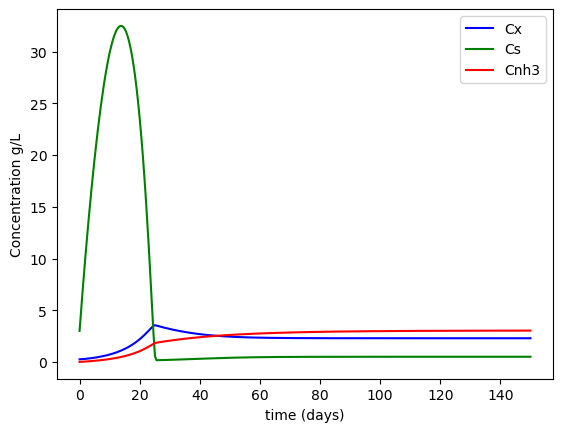

In [42]:
tmax = 150                              
tspan=numpy.linspace(0,tmax,300)            
tper = (0,tmax)                          

CorNi = solve_ivp(ferm_eq, tper, Co, dense_output = True, method = "LSODA")    

Cs, Cx, Nch4, Nco2, Cnh3,Cr = CorNi.sol(tspan)

plt.figure(3)
plt.plot(tspan, Cx*MMx, color='blue', label='Cx')
plt.plot(tspan, Cs*MMs, color='green', label='Cs')
plt.plot(tspan, Cnh3*17, color='red', label='Cnh3')
plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (days)') 
plt.show() 

From this graph, ensure that you can calculate the final $C_S,C_X,C_{NH_3}$ values as:

[0.5, 2.28, 3.04]

Let's determine organic loading rate


In [43]:
Q=D*V #l/day
Ns=(120*Q)/2 #g/day/l
Ns

4.8

a) Now set up a steady state ferm_eq in order to use fsolve to solve for the steady state. Ensure to neglect the gasses in this equation as a steady state concentration won't be reached for methane and $CO_2$. Ensure that you get the same answer as the end of the dynamic simulation given above. 

b) Determine the biogas production rate at steady state in $\frac{L}{day}$

9.2 $\frac{L}{day}$

c) What is the methane fraction of the biogas at steady state?

57%


d) Determine the liters of biogas produced per gram of substrate fed.

0.96

e) Assume there is a sudden change in the feed substrate concentration to 160 $\frac{g}{L}$. Show that the dynamic response will look like this. Try and explain the shapes obtained.

<img src="graph2.png" width="600" />

f) Use fsolve to calculate the new steady state of the $C_S,C_X,C_{NH_3}$ values:

[0.5, 3.06, 4.05]

Why is $C_S$ the same as before? Why did $C_X$ and $C_{NH_3}$ increased.

Show tat the biogas is now 12.3 $\frac{L}{day}$ with a $CH_4$ fraction of 57%

Show that the substrate conversion has increased from 99.58% to 99.69%. Explain why

g) Let's change the dilution rate to 15 $\frac{1}{day}$. You should get that $C_S$ is now 1.07 $\frac{g}{L}$ and $C_X$ now 4.26 $\frac{g}{L}$. Show that substrate conversion has dropped from 99.69% to 99.33%. 

Show that substrate used for maintenance has decreased from 90.6% to 86.8%. Why did this ratio change?


h) Prove to yourself that the maximum fraction of glucose used for growth can not exceed 24.2% at high substrate concentrations in the reactor mixture.

i) Let's decrease $\theta_{max}$ to 0.2 $\frac{mmol}{g\cdot day}$. D=1/25 $\frac{1}{day}$ and $C_S$ in feed is 160 $\frac{g}{L}$. Show that $C_S,C_X,C_{NH_3}$ at steady state is now:

[0.5, 16.55, 3.25]

Explain the difference in $C_X$ compared to the same conditions before (e and f)

Explain the difference in $C_{NH_3}$ compared to the same conditions before (e and f)

Show that the substrate used for maintenance is now 49.1%



j) Return to  $\theta_{max}$ to 2 $\frac{mmol}{g\cdot day}$. Determine the steady state outlet concentrations as a function of D. You should get the following: 

<img src="graph3.png" width="600" />

At what D does washout occur?

Show that for $\theta_{max}$ =0.2 $\frac{mmol}{g\cdot day}$, the above graph will look as follow:

<img src="graph4.png" width="600" />


$r_X=D=\mu-\mu_D$
